# Polynomial Regression - Bayesian Approach


<font color=red size=3> **Application Scenario:**</font> 
The Bayesian Polynomial Regression or Regularized Polynomial Regression is suitable for the following scenario.
- Relationship between input (features) and output (target): Non-Linear
- The Polynomial Regression model is too complex and overfits the data (high variance)
- We need a complex model but want to "turn-off" the unnecessary polynomial features. In other words, we want to regularize the complex model.



## Choosing Model Complexity in High-Degree Polynomial Regression

There are two approaches to make an optimal tradeoff between overfitting (high variance) and underfitting (high bias).
- <font color=red>Frequentist Learning (MLE)</font>: 
   
   -- Using cross-validation determine the optimal degree (model complexity) that produces best generalization
   
   -- Using learning curve determine the optimal degree (model complexity) that produces best generalization
   
- <font color=red>Bayesian Learning (MAP or regularized regression)</font>: 
   
   -- Using cross-validation learn the optimal regularization (penalty) coefficients that produce best generalization


##### In this notebook we implement the Bayesian approach.
We perform **regularized polynomial linear regression** using the sklearn's **regularized OLS Linear Regression** model.


### Dataset

URL: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

This dataset provides housing values in suburbs of Boston.

The **MEDV** variable is the target variable.

### Data description

The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

- CRIM: per capita crime rate by town.

- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

- INDUS: proportion of non-retail business acres per town.

- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- NOX: nitrogen oxides concentration (parts per 10 million).

- RM: average number of rooms per dwelling.

- AGE: proportion of owner-occupied units built prior to 1940.

- DIS: weighted mean of distances to five Boston employment centres.

- RAD: index of accessibility to radial highways.

- TAX: full-value property-tax rate per $10,000.

- PTRATIO: pupil-teacher ratio by town.

- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

- LSTAT: lower status of the population (percent).

- MEDV: median value of owner-occupied homes in $1000s.

In [1]:
import warnings
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Load Data

First load the data and explore the feature names, target names, etc.

In [2]:
# Load data
boston = datasets.load_boston()
print(boston.data.shape, boston.target.shape)
print(boston.feature_names)

(506, 13) (506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## Create A DataFrame Object

In [3]:
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df = pd.concat([df,pd.Series(boston.target,name='MEDV')],axis=1)

# Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.


In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Description of the Data

DataFrame’s info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


# Explore the Data: Describe Numerical Attributes

DataFrame's describe() method shows a summary of the numerical attributes.

In [6]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Create a Separate Feature Set (Data Matrix X) and Target (1D Vector y)

Create a data matrix (X) that contains all features and a 1D target vector (y) containing the target.



In [7]:
import numpy as np

# It contains all attributes (all features and the target)
allData = df


# Use the following code to select ALL features
X = df.drop(columns='MEDV')  # Data Matrix containing all features excluding the target


y = df['MEDV'] # 1D targer vector

print(X.shape)
print(y.shape)

(506, 13)
(506,)


# Scale The Features

We should ensure that all features have a similar scale. Otherwise optimization algorithms (e.g., Gradient Descent based algorithms) will take much longer time to converge.

Also, regularization techniques are sensitive to the scale of data. Thus, we must scale the features before applying regularization.

In [8]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Create Train and Test Dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bayesian Learning Approach for Bias-Variance Tradeoff (Choosing Model Complexity)


Unlike the Frequentist approach (MLE) that is used to determine optimal degree of the polynomial (how complex the model should be), the Bayesian approach enables us to determine the optimal regularization (penalty) coefficients that produce best generalization.

Recall that MLE pics the polynomial degree that is the best for modeling the training data. If the data is noisy (input and out has non-linear relationship), a high-degree polynomial is requred that results in a complex function. Such complex models are prone to overfitting (shows high variance).

The Bayesian approach (Maximum a posteriori or MAP) is used to resolve this issue by encouraging the parameters to be small, thus resulting in a smoother curve. This is done by a technique called **regularization**. Regularization can “turn-off” some features that don’t play any role explaining the variation in our prediction. In polynomial regression, it kills the non-contributing polynomial features.

Regularization allows complex models to be trained on data sets of limited size without severe overfitting, essentially by limiting the effective model complexity. We can afford a complex model without experiencing overfitting.



### Regularized (Penalized) Regression


In regularized Regression we regularize (penalize) the model parameters that allow complex models (high-degree Polynomial Regression model) to be trained on datasets of limited size without severe overfitting. It essentially limits the effective model complexity. 

Thus, the problem of determining the optimal model complexity (degree of polynomial or the basis function) is shifted from one of finding the appropriate number of basis functions (that we did in the Frequentist approach) to one of determining a suitable value of the regularization coefficient.

A model with some regularization typically performs better than a model without any regularization. Thus, we should generally prefer regularized Regression over plain Linear Regression.

Moreover, the OLS method (Normal Equation) requires computing the inverse of a matrix, but that matrix is not always invertible. In contrast, the matrix for regularized Regression (e.g., Ridge Regression) is always invertible.

To implement the Bayesian approach, we will train a high-degree polynomial model that might have high-variance (suffers from overfitting). Then, we will reduce overfitting via regularization. First, we determine the optimal polynomial degree by using MLE and then reduce its overfitting.
- Step 1: Using MLE determine the optimal degree of the high-degree polynomial.
- Step 2: Then, apply the regularized OLS method (MAP) and determine the optimal value for the regularization parameter via hyperparameter tuning. We will see that due to regularization the model will be better generalizable by weaking some of the features.



## Step 1: Using MLE Determine the Optimal Degree of the Polynomial


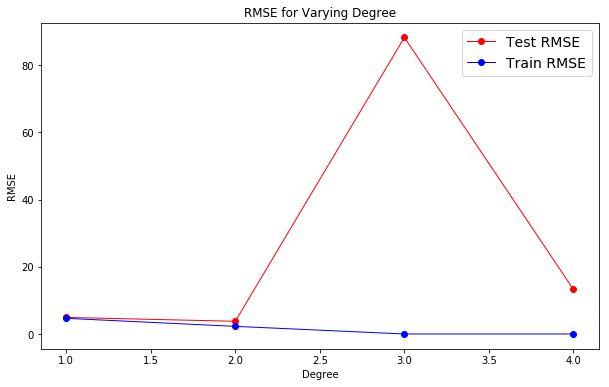


Optimal Degree:  2


In [10]:
degreeList = [1,2,3,4]

mse_train, mse_test = [], []

for degree in degreeList:

    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    model.fit(X_train, y_train)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    
    mse_train.append(mean_squared_error(y_train, y_train_predicted))
    mse_test.append(mean_squared_error(y_test, y_test_predicted))
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_test), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(degreeList, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE") 
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value of optimal degree for the polynomial that gives smallest RMSE

rmse_test = np.sqrt(mse_test)
j = 0
min_rmse = rmse_test[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_test[j] < min_rmse):
        min_rmse = rmse_test[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)

## Step 2: Apply the Regularized OLS Method (MAP) on the Optimal Polynomial Model


There are three different regularized OLS models.

- Ridge Regression ($l_2$ norm)
- Lasso Regression ($l_1$ norm)
- Elastic Net (it combines $l_1$ and $l_2$ priors as regularizer)

We will use the OLS Ridge and Lasso Regression algorithms on the high-degree polynomial dataset.


#### Using cross-validation we determine the optimal regularization (penalty) coefficients that produce best generalization.


## Ridge Regression

We will implement the Ridge Regression with Scikit-Learn using a closed-form solution. It uses a matrix factorization technique by André-Louis **Cholesky**. However, there are other solvers that we can choose from.

We need to find optimal values for the following **two hyperparameters** of the Ridge regression model.

- alpha : {float, array-like}, shape (n_targets)
Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization.

- solver : {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’}

The solvers:
1. ‘svd’ uses a Singular Value Decomposition of X to compute the Ridge coefficients. More stable for singular matrices than ‘cholesky’.
2. ‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution.
3. ‘sparse_cg’ uses the conjugate gradient solver as found in scipy.sparse.linalg.cg. As an iterative algorithm, this solver is more appropriate than ‘cholesky’ for large-scale data (possibility to set tol and max_iter).
4. ‘lsqr’ uses the dedicated regularized least-squares routine scipy.sparse.linalg.lsqr. It is the fastest and uses an iterative procedure.
5. ‘sag’ uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.
6. ‘auto’ chooses the solver automatically based on the type of data.


## Model Selection: Hyperparameter Tunining


We need to select the best model based on the optimal values of these hyperparameters. This process is called hyperparameter tuning.

The best way to do hyperparameter tuning is to use **cross-validation**.

We will use Scikit-Learn’s GridSearchCV to search the combinations of hyperparameter values that provide best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 


### Important:

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For regression, we may use "neg_mean_squared_error" or "explained_variance" scoring function. 



## Create a High-Degree Polynomial Data Matrix

In [11]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)


print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])

No. of Original Features:  13
No. of Augmented Features:  104


## Model Selection Via Grid Search: Ridge Regression

In [12]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values

param_grid = {'alpha': np.linspace(0.01, 1.0, num=20), 
              'solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga"]}

ridge = Ridge()

ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
ridge_cv.fit(X_train_poly, y_train)


params_optimal_ridge = ridge_cv.best_params_

print("Best Score (negative mean squared error): %f" % ridge_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_ridge)
print("\n")

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s


Best Score (negative mean squared error): -13.650130
Optimal Hyperparameter Values:  {'alpha': 0.01, 'solver': 'saga'}


CPU times: user 1.36 s, sys: 133 ms, total: 1.49 s
Wall time: 9.83 s


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    9.7s finished


## Select The Best Model for the Ridge Regressor

Using the optimal hyperparameter values, create the best model.
Then, fit the model.

In [13]:
# Ridge Regression


# Optimal model parameters
ridge_alpha = ridge_cv.best_params_['alpha']
print("Optimal alpha: ", ridge_alpha)

ridge_solver = ridge_cv.best_params_['solver']
print("Optimal alpha: ", ridge_solver)


# Create Ridge linear regression object
lin_reg_ridge = Ridge(alpha=ridge_alpha, solver=ridge_solver)

# Train the model
lin_reg_ridge.fit(X_train_poly, y_train)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_ridge = lin_reg_ridge.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_ridge))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_ridge))

Optimal alpha:  0.01
Optimal alpha:  saga

----------------------------- Model Evaluation -----------------------------

Mean squared error: 8.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.90


## Evaluate the Model Using Test Data: Ridge Regression

We will use the optimal degree for the polynomial to evaluate the model.

In [14]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_ridge.predict(X_test_poly)


ridge_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % ridge_test_mse)



ridge_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % ridge_test_r2_score)



----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 12.93
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.82


# Lasso Regression



## Create a High-Degree Polynomial Data Matrix

In [15]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

## Model Selection Via Grid Search: Lasso Regression

In [16]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values

#param_grid = {'alpha': np.linspace(10.0, 20.0, num=10)}
param_grid = {'alpha': np.linspace(10.0, 20.0)}

lasso = Lasso()

lasso_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train_poly, y_train)

params_optimal_lasso = lasso_cv.best_params_

print("Best Score (negative mean squared error): %f" % lasso_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_lasso)
print("\n")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Score (negative mean squared error): -12.208312
Optimal Hyperparameter Values:  {'alpha': 15.510204081632654}


CPU times: user 529 ms, sys: 182 ms, total: 711 ms
Wall time: 576 ms


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


## Select The Best Model for the Lasso Regressor

Using the optimal hyperparameter values, create the best model.
Then, fit the model.

In [17]:
# Lasso Regression

# Optimal model parameters
lasso_alpha = lasso_cv.best_params_['alpha']
print("Optimal alpha: ", lasso_alpha)


# Create Lasso linear regression object
lin_reg_lasso = Ridge(alpha=lasso_alpha)

# Train the model
lin_reg_lasso.fit(X_train_poly, y_train)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_lasso = lin_reg_lasso.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_lasso))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_lasso))

Optimal alpha:  15.510204081632654

----------------------------- Model Evaluation -----------------------------

Mean squared error: 6.57
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.92


## Evaluate the Model Using Test Data: Lasso Regression

We will use the optimal degree for the polynomial to evaluate the model.

In [18]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_lasso.predict(X_test_poly)

lasso_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % lasso_test_mse)


# Explained variance score: 1 is perfect prediction

lasso_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % lasso_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 13.29
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.82


##  Ridge Regression vs. Lasso Regression


Lasso Regression uses an $l_1$ penalty, which tends to push the weights down to exactly zero. This leads to **<font color=red>sparse models</font>**, where all weights are zero except for the most important weights. This is a way to perform **feature selection** automatically, which is good if we suspect that only a few features actually matter. When we are not sure, we should prefer Ridge Regression.


## Comparison of the Weight Values: Ridge Regression vs. Lasso Regression

We will see that when the regularization coefficient (alpha) is large (e.g., $ \geq 1.0$), Lasso regression tends to drive the weight values towards 0.

In [19]:
print("%8s (alpha = %3.3f)  %10s (alpha = %3.3f)" % ("Ridge",ridge_alpha, "Lasso", lasso_alpha))
print("%2s Test MSE = %3.3f  %8s Test MSE = %3.3f" % (" ",ridge_test_mse, " ", lasso_test_mse))
print("%2s Test R2 Score = %3.3f  %4s Test R2 Score = %3.3f" % (" ",ridge_test_r2_score, " ", lasso_test_r2_score))
print("________________________________________________________________\n")
for i in range(lin_reg_ridge.coef_.shape[0]):
    print("%15f  %30f" % (lin_reg_ridge.coef_[i], lin_reg_lasso.coef_[i]))
    

   Ridge (alpha = 0.010)       Lasso (alpha = 15.510)
   Test MSE = 12.925           Test MSE = 13.292
   Test R2 Score = 0.824       Test R2 Score = 0.819
________________________________________________________________

      -0.181449                       -0.113237
       0.047159                        0.035266
      -0.266529                       -0.046317
       0.078989                        0.088411
      -0.524234                       -0.730552
       3.013070                        3.284779
      -0.538919                       -0.830703
      -0.607133                       -1.376246
       0.213348                        0.632927
      -0.562102                       -0.836610
      -0.960287                       -0.759206
       0.346323                        0.522407
      -2.589432                       -2.936501
       0.080660                        0.033523
       0.067011                        0.041845
       0.005558                        0.090824
       0.5

## Final Note: Regularized Polynomial Regression

We observe that only by increasing model complexity (higher-degree polynomial) and regularizing its weights, we could improve performance on the test data for the given dataset.